In [1]:
# import relevant packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats as ss
import seaborn as sns
from tqdm import tqdm

import torch
import torch_geometric
from torch_geometric.loader import DataLoader

# set figure parameters
sc.settings.set_figure_params(dpi=100)

Advancements in genomics and machine learning have revolutionized both fields and for instance have culminated in models of Virtual Cells which predict the effect that changes in the micro- and macro-environment of the cell (such as perturbing the age of the donor, the tissue the cell is in, the drug treatment, knock-outs from guide RNAs etc) have on gene expression. 

Conversely, models of Virtual Tissues aim to not only estimate the effect the environment has on the cell but also the effect that the cell has on its environment and overall tissue.

Celcomen attempts to handle this problem using a causally identifiable GenAI framework which consists of two parts: the inference module (CCE) which uses spatial transcriptomics data to learn the values of gene-gene forces (up to their Markov equivalence class) and disentangle them to intra- and inter-cellular components; and the generative module (SCE) which uses the learned gene-gene forces to predict the effect of spatial counterfactuals, such as gene knokouts and cell injections, on the tissue.

The required inputs are raw gene counts stored as anndata. Download the cell_feature_matrix and cells.csv.gz from [10x_human_glioblastoma](https://www.10xgenomics.com/datasets/ffpe-human-brain-cancer-data-with-human-immuno-oncology-profiling-panel-and-custom-add-on-1-standard) and extract them into a directory labelled "data" in the same directory as this notebook, before proceeding. 




# Pre-processing

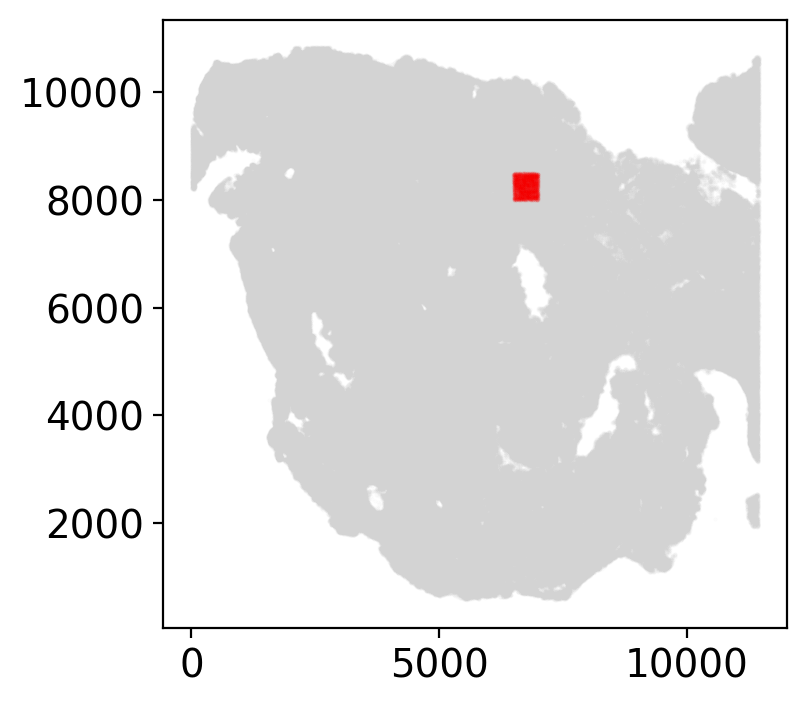

In [2]:
# read in xenium
avis = sc.read_10x_h5('data/xenium_human_gbm/cell_feature_matrix.h5')
avis.var_names = avis.var_names.astype(str)
avis.var_names_make_unique()
# remove cells with no counts
sc.pp.filter_cells(avis, min_counts=100)
# normalize the data
sc.pp.normalize_total(avis, target_sum=1e6)
sc.pp.log1p(avis)
# read in the spatial
df = pd.read_csv('data/xenium_human_gbm/cells.csv.gz', index_col=0)
df = df.loc[avis.obs.index]
# view the tissue and choose a specific area to focus on
fig, ax = plt.subplots()
ax.grid(False)
ax.scatter(df['x_centroid'], df['y_centroid'], s=0.1, alpha=0.1, color='lightgray')
mask = (df['x_centroid'] < 7000) & (df['x_centroid'] > 6500)
mask = mask & (df['y_centroid'] < 8500) & (df['y_centroid'] > 8000)
ax.scatter(df.loc[mask, 'x_centroid'], df.loc[mask, 'y_centroid'], s=0.1, alpha=0.1, color='r')

/nfs/team205/sm58/packages/celcomen_trials/pyg_env/celcomen_tutorial_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
/nfs/team205/sm58/packages/celcomen_trials/pyg_env/celcomen_tutorial_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


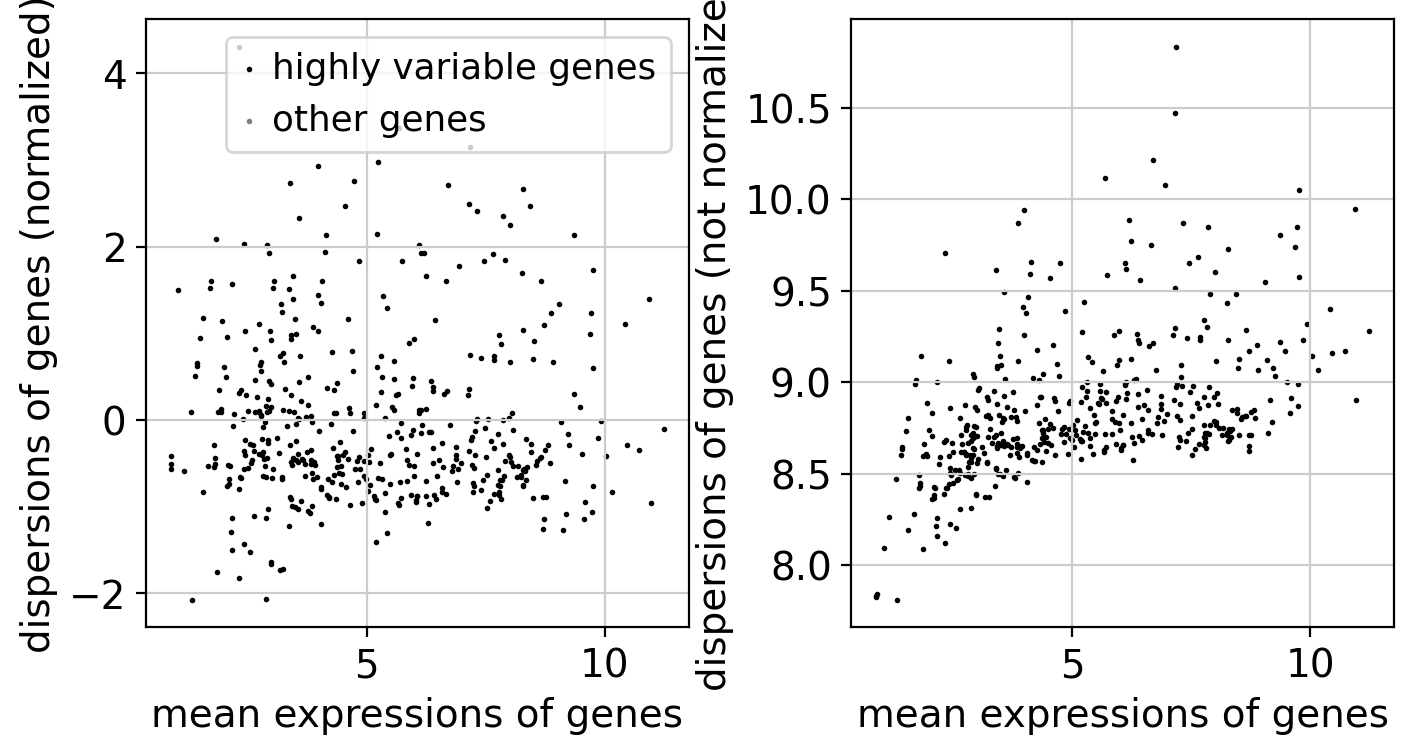

there are 480 hvgs


In [3]:
# add spatial and subset
avis.obsm['spatial'] = df.loc[avis.obs.index, ['x_centroid','y_centroid']].values
avis = avis[mask].copy()
# compute PCA for the spatial dataset using HVGs
avis.uns['log1p']['base'] = np.e
sc.pp.highly_variable_genes(avis, flavor='seurat', min_mean=0.5, max_mean=7.5, min_disp=0.5, n_top_genes=avis.shape[1])
sc.pl.highly_variable_genes(avis)
# report how many HVGs we're going to use
print('there are', avis.var['highly_variable'].sum(), 'hvgs')

In [4]:
from scipy.spatial.distance import pdist, squareform
# create a gene subset for testing
genes = avis.var_names[avis.var['highly_variable']].tolist()
avis = avis[:, genes ].copy()

# retrieve positions from the data # only needed for simcomen later
pos = torch.from_numpy(df[['x_centroid','y_centroid']].values)
# convert the gene expression data to numpy
x = torch.from_numpy(avis[:, genes].X.todense())
# sphere normalize the data (just in case)
norm_factor = torch.pow(x, 2).sum(1).reshape(-1,1)
assert (norm_factor > 0).all()
x = torch.div(x, norm_factor)
# compute the distances
distances = squareform(pdist(df.loc[mask, ['x_centroid','y_centroid']]))
# compute the edges as two cell widths apart so 30µm
edge_index = torch.from_numpy(np.array(np.where((distances < 15)&(distances != 0))))

avis.obs["sangerID"] = "sample1"

avis.write_h5ad(
    'data/xenium_human_gbm/avis_preprocessed.h5',
)

# Run inference module to learn intra- and inter-cellular gene-gene forces

In [5]:
# load model
from celcomen.models.celcomen import celcomen
from celcomen.models.simcomen import simcomen

from celcomen.training_plan.train import train
from celcomen.datareaders.datareader import get_dataset_loaders

from celcomen.utils.helpers import calc_gex, get_pos, get_pos, calc_sphex, normalize_g2g

In [6]:
h5ad_path='data/xenium_human_gbm/avis_preprocessed.h5'
n_neighbors=6
loader = get_dataset_loaders(h5ad_path, "sangerID", n_neighbors, 'cuda', True, )

Step 1
=====
Number of graphs in the current batch: 1
DataBatch(x=[1781, 480], edge_index=[2, 7724], y=[1], pos=[1781, 2], batch=[1781], ptr=[2])



### Select the hyperparameters of the model.
zmft_scalar should be the highest value in the range (0,1) such that the loss can be stably minimized. 
n_neighbors should be selected based on what disentanglement we want to achieve in the data. n_neighbors=6 targets disentanglement between intracellular and intercellular forces of short range.

In [7]:
n_genes = len(genes)
learning_rate = 5e-2
zmft_scalar = 1e-1
seed = 0
epochs = 200


model = celcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
model.to("cuda")
input_g2g = np.random.uniform(size=(n_genes, n_genes)).astype('float32')
input_g2g = normalize_g2g((input_g2g + input_g2g.T) / 2)

model.set_g2g(torch.from_numpy(input_g2g))
model.set_g2g_intra(torch.from_numpy(input_g2g))
model.to("cuda")

losses = train(epochs, learning_rate, model, loader, zmft_scalar=zmft_scalar, seed=1, device="cuda")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 46.85it/s]


[Text(0.5, 0, 'epochs'), Text(0, 0.5, 'loss')]

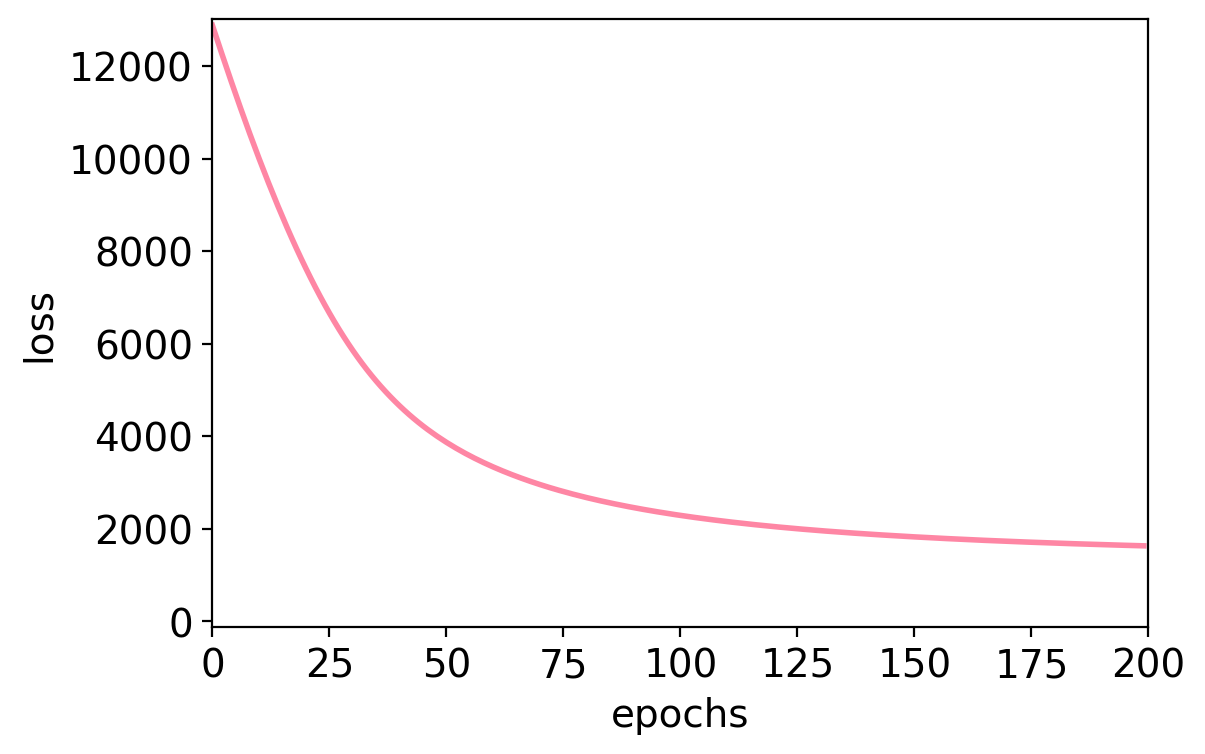

In [8]:
# create the plot
fig, ax = plt.subplots(figsize=[6, 4])
ax.grid(False)
ax.plot(losses, lw=2, color='#fe86a4')
ax.set_xlim(0, epochs)
vmin, vmax = min(min(losses), 0), max(losses)
vstep = (vmax - vmin) * 0.01
ax.set_ylim(vmin-vstep, vmax+vstep)
ax.set(xlabel='epochs', ylabel='loss')

The stable optimization of Celcomen indicates that zmft_scalar has been chosen appropriately.

# Run the generative module: to predict the effect of gene knock-outs 

The process of making a counterfactual prediction consists in: 

1) creating a prompt spatial transcriptomic dataset
2) use Simcomen (SCE) to make the counterfactual prediction based on the prompt

#### Create prompt 

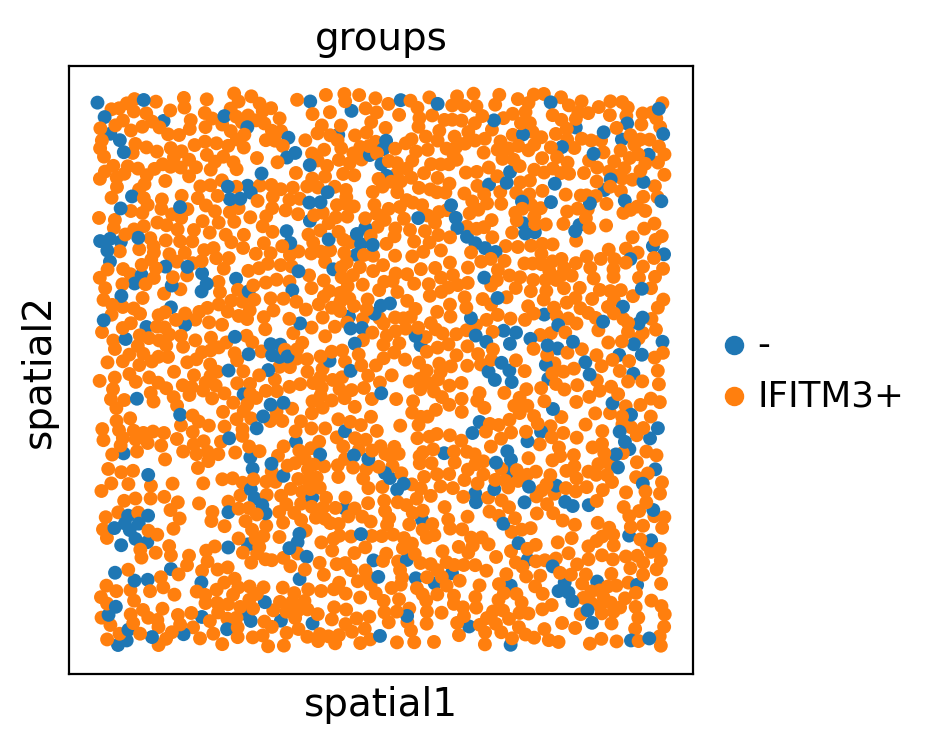

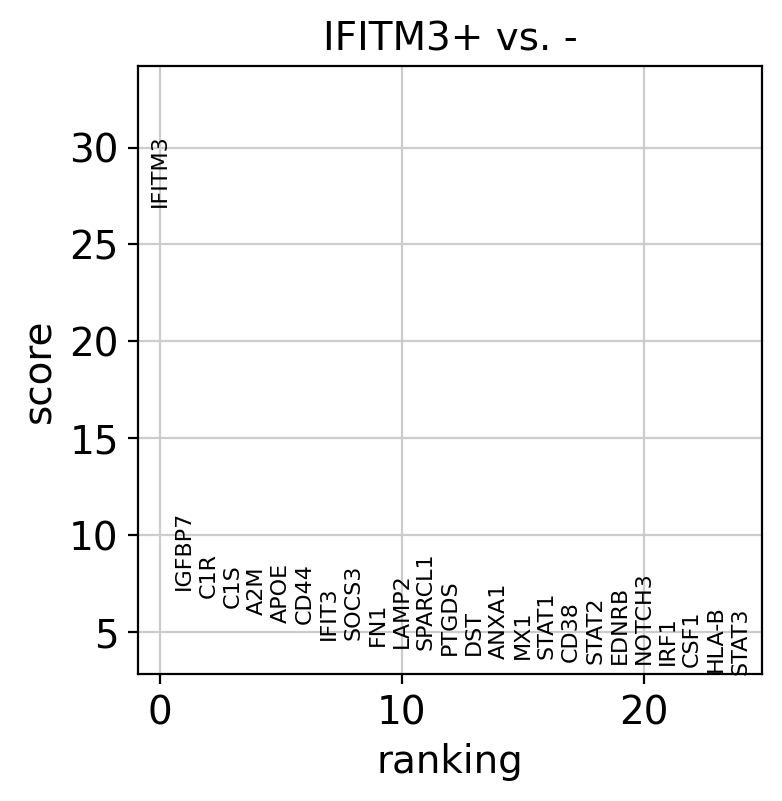

In [9]:
# define the genes that distinguish ISG15 spots currently
avis_sub = avis.copy()
avis_sub.obs['groups'] = (sc.get.obs_df(avis_sub, keys=['IFITM3']).max(1) > 0).map({True:'IFITM3+', False:'-'})
sc.pl.embedding(avis_sub, basis='spatial', color=['groups'], use_raw=False, s=1e2)
# calculate differential expression
sc.tl.rank_genes_groups(avis_sub, method='wilcoxon', use_raw=False, groupby='groups', group=['IFITM3+'], reference='-')
sc.pl.rank_genes_groups(avis_sub, n_genes=25, sharey=False)

In [10]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

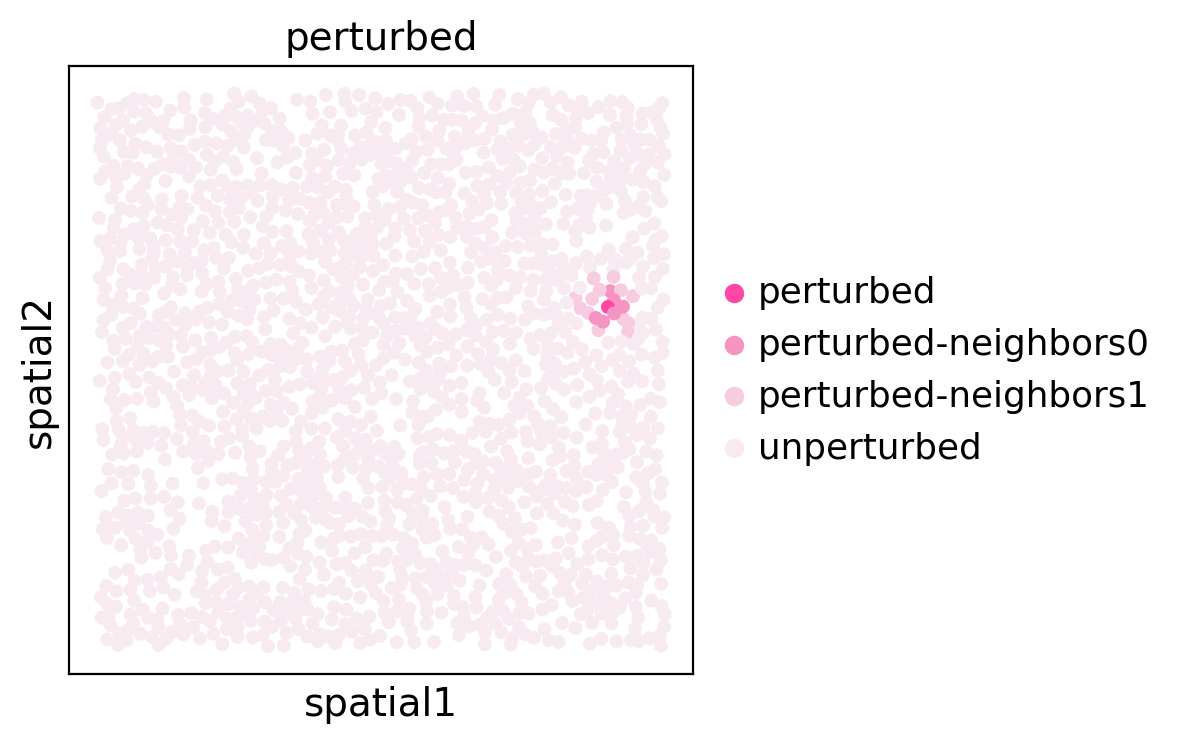

In [11]:
# propose an X introducing ISG15 inflammation
prompt_x = avis_sub.X.toarray().copy()
# adjust the X so we artificially introduce signaling to the center left side of the tissue
np.random.seed(0)
df_gex = sc.get.obs_df(avis_sub, keys=['IFITM3'])['IFITM3']
mask = avis_sub.obs.index == np.random.choice(avis_sub.obs.index[df_gex > 0], size=1)[0]
idx = np.where(avis_sub.var_names == 'IFITM3')[0][0]
prompt_x[mask, idx] = 0
avis_sub.obs['perturbed'] = 'unperturbed'
avis_sub.obs['perturbed'].iloc[np.where(squareform(pdist(avis_sub.obsm['spatial']))[mask, :] < 30)[1]] = 'perturbed-neighbors1'
avis_sub.obs['perturbed'].iloc[np.where(squareform(pdist(avis_sub.obsm['spatial']))[mask, :] < 15)[1]] = 'perturbed-neighbors0'
avis_sub.obs.loc[mask, 'perturbed'] = 'perturbed'
avis_sub.uns['perturbed_colors'] = ['#ff47a6','#f593c2','#f7cbe0','#f7ebf1']
sc.pl.embedding(avis_sub, basis='spatial', color=['perturbed'], use_raw=False, s=1e2)

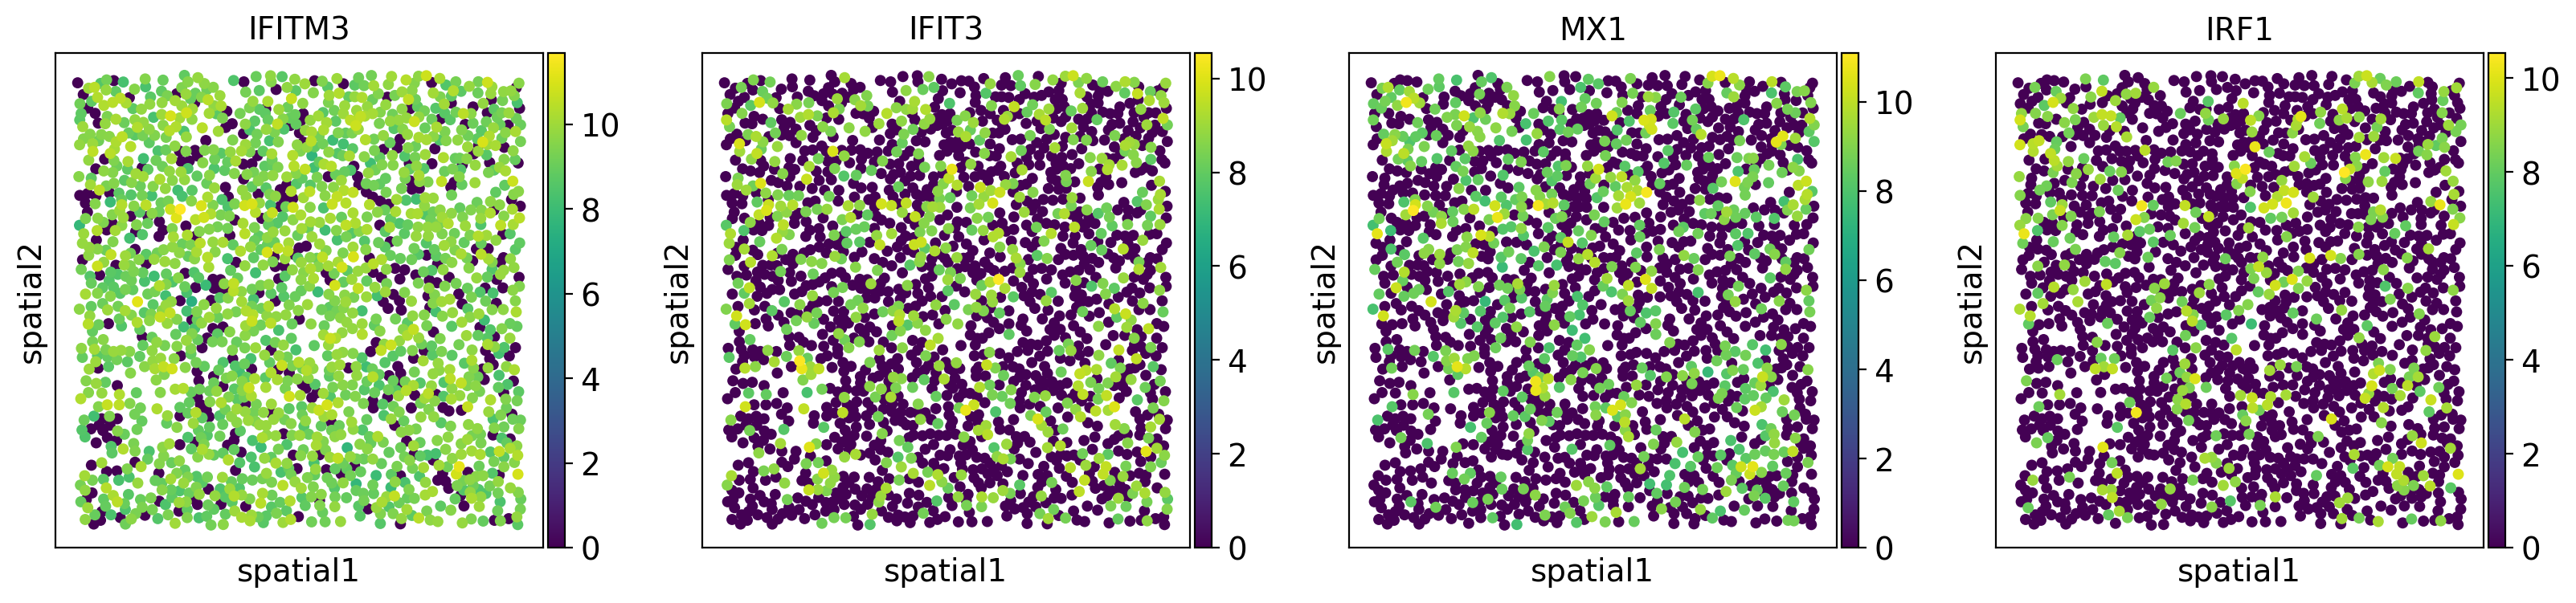

In [12]:
# demonstrate what the proposed x looks like pre scaling
avis_sub.X = prompt_x
sc.pl.embedding(avis_sub, basis='spatial', color=['IFITM3','IFIT3','MX1','IRF1'], use_raw=False, s=1e2)

### Run Simcomen

In [13]:
# define the parameters of the model
n_genes = avis_sub.shape[1]
learning_rate = 1e-3
zmft_scalar = 1e-1
seed = 0
epochs = 50
# instantiate the model, input and output will be the same
simmodel = simcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
# now perform the simulation
np.random.seed(seed)
# convert the gene expression data to numpy
x = torch.from_numpy(prompt_x)
# sphere normalize the data (just in case)
norm_factor = torch.sqrt(torch.pow(x, 2).sum(1)).reshape(-1,1)
assert (norm_factor > 0).all()
x = torch.div(x, norm_factor)
# artifically set the g2g matrix
simmodel.set_g2g(model.conv1.lin.weight.clone().detach())
simmodel.set_g2g_intra(model.lin.weight.clone().detach())
# initialize a gene expression matrix
assert np.isnan(x.detach().numpy()).sum() == 0
input_sphex = calc_sphex(x.to('cuda')).clone()

# move tensors and model to device cuda
device="cuda"
simmodel.set_sphex(input_sphex)
simmodel.to(device)

# set up the optimizer
optimizer = torch.optim.SGD(simmodel.parameters(), lr=learning_rate, momentum=0)

In [14]:
# keep track of the losses per data object
loss, losses = None, []
# train the model
simmodel.train()
tmp_gexs = []
# work through epochs
edge_index = edge_index.to('cuda')
for epoch in tqdm(range(epochs), total=epochs):
    # derive the message as well as the mean field approximation
    msg, msg_intra, log_z_mft = simmodel(edge_index, 1)
    if (epoch % 5) == 0:
        tmp_gex = simmodel.gex.clone().detach().cpu().numpy()
        tmp_gexs.append(tmp_gex)
    # compute the loss and track it
    loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(simmodel.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model.gex))) )
    losses.append(loss.detach().cpu().numpy()[0][0])
    # derive the gradients, update, and clear
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [16:52<00:00, 20.24s/it]


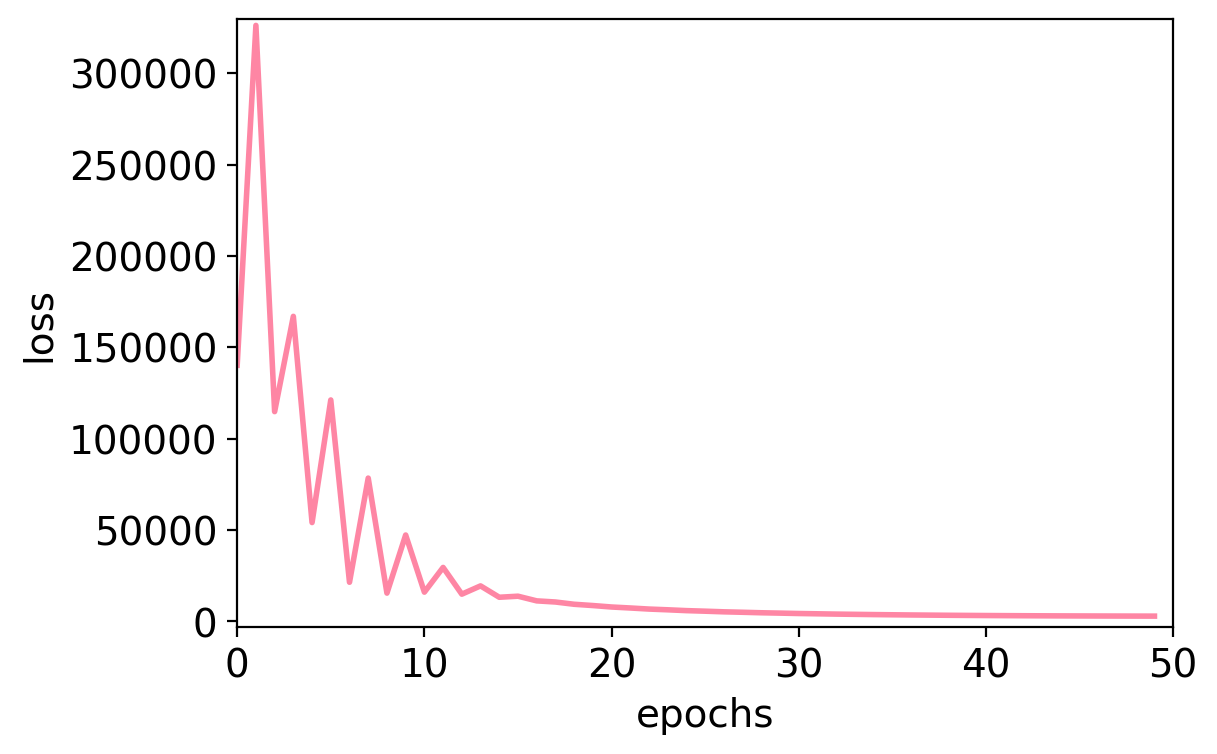

In [15]:
# plot the loss
fig, ax = plt.subplots(figsize=[6, 4])
ax.grid(False)
ax.plot(losses, lw=2, color='#fe86a4')
ax.set_xlim(0, epochs)
vmin, vmax = min(min(losses), 0), max(losses)
vstep = (vmax - vmin) * 0.01
ax.set_ylim(vmin-vstep, vmax+vstep)
ax.set(xlabel='epochs', ylabel='loss')
# retrieve the data
output_gex = simmodel.gex.detach().cpu().numpy()
output_msg = msg.detach().cpu().numpy()

Stable optimization of Simcomen indicates that zmft_scalar has been chosen appropriately for this dataset.

# Downstream analysis and Visualization

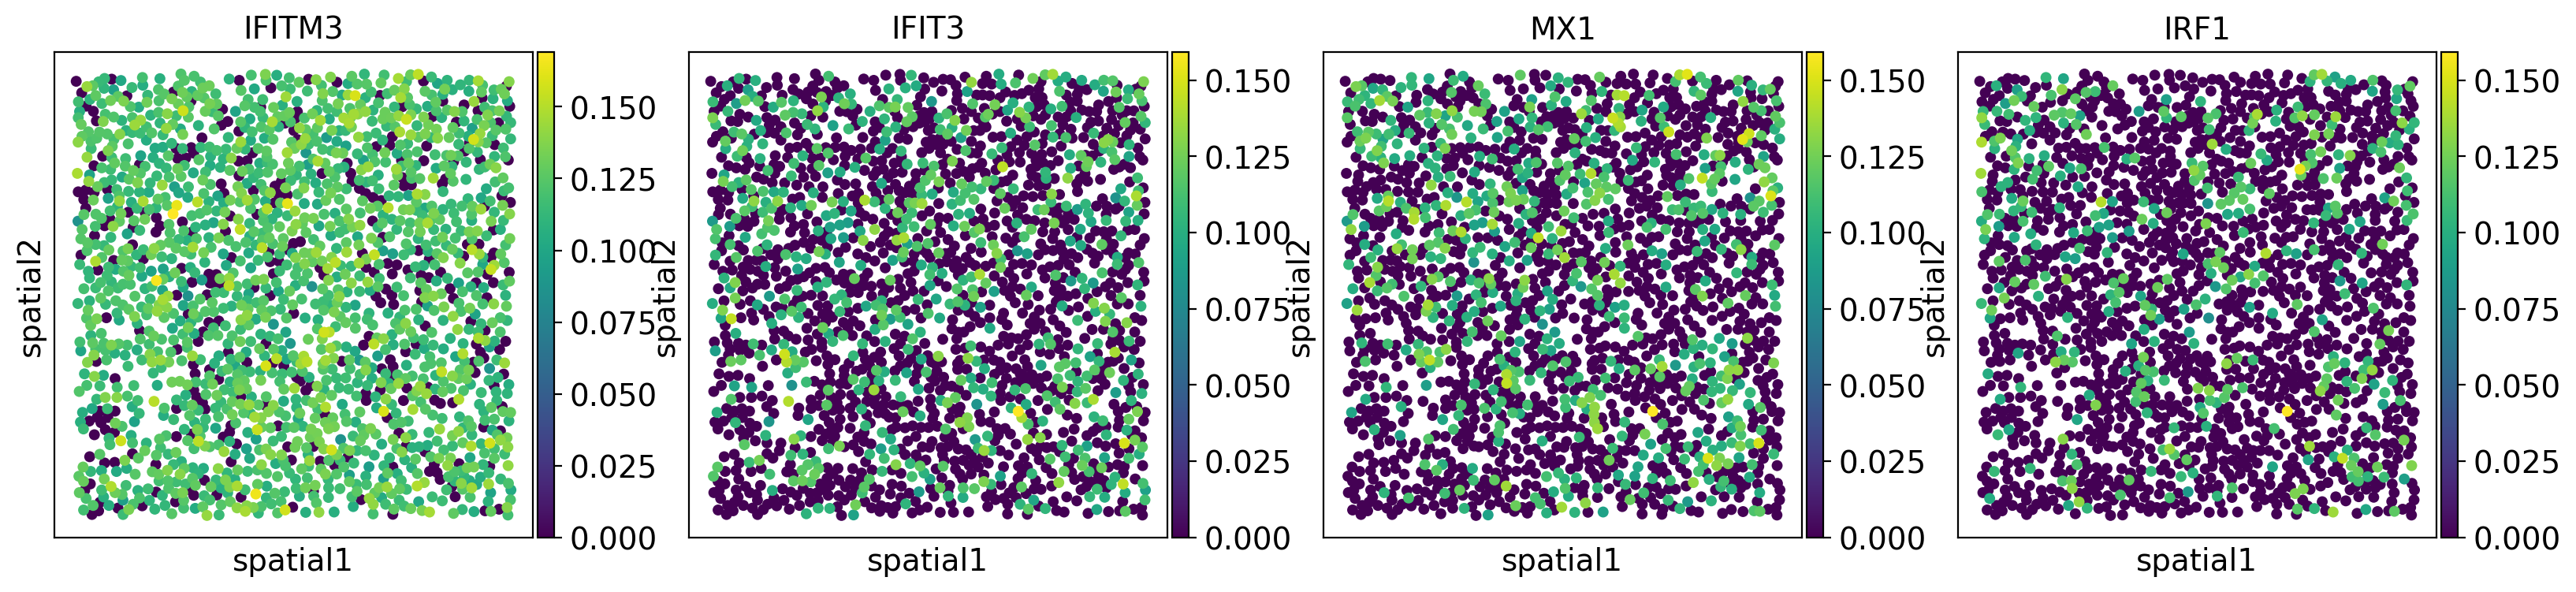

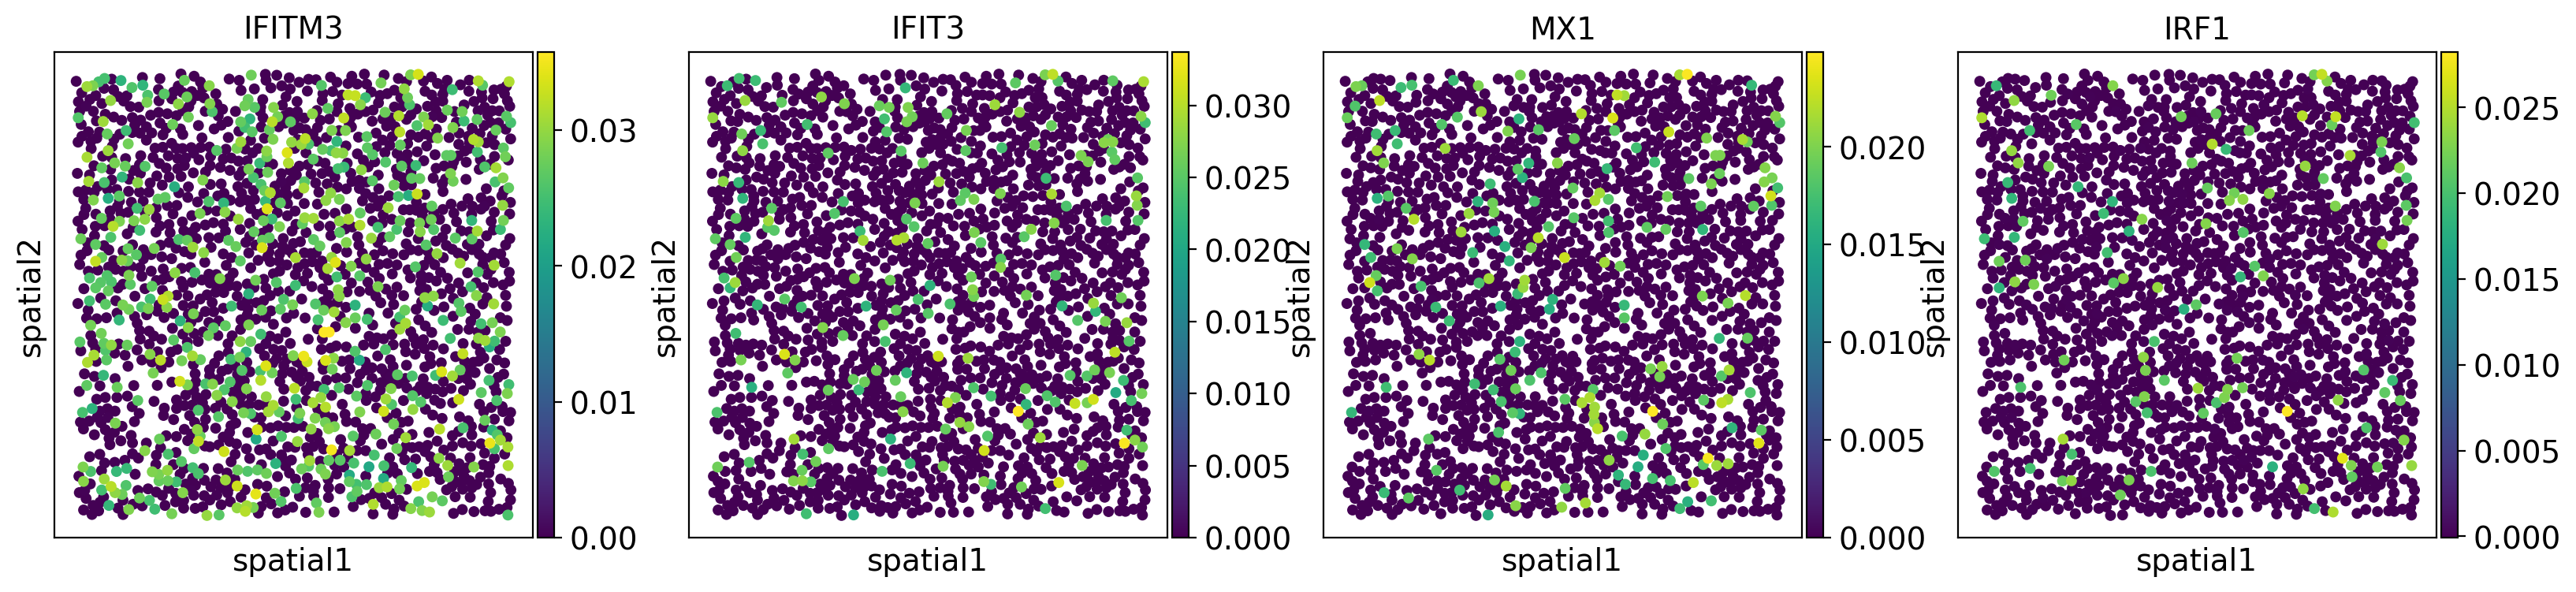

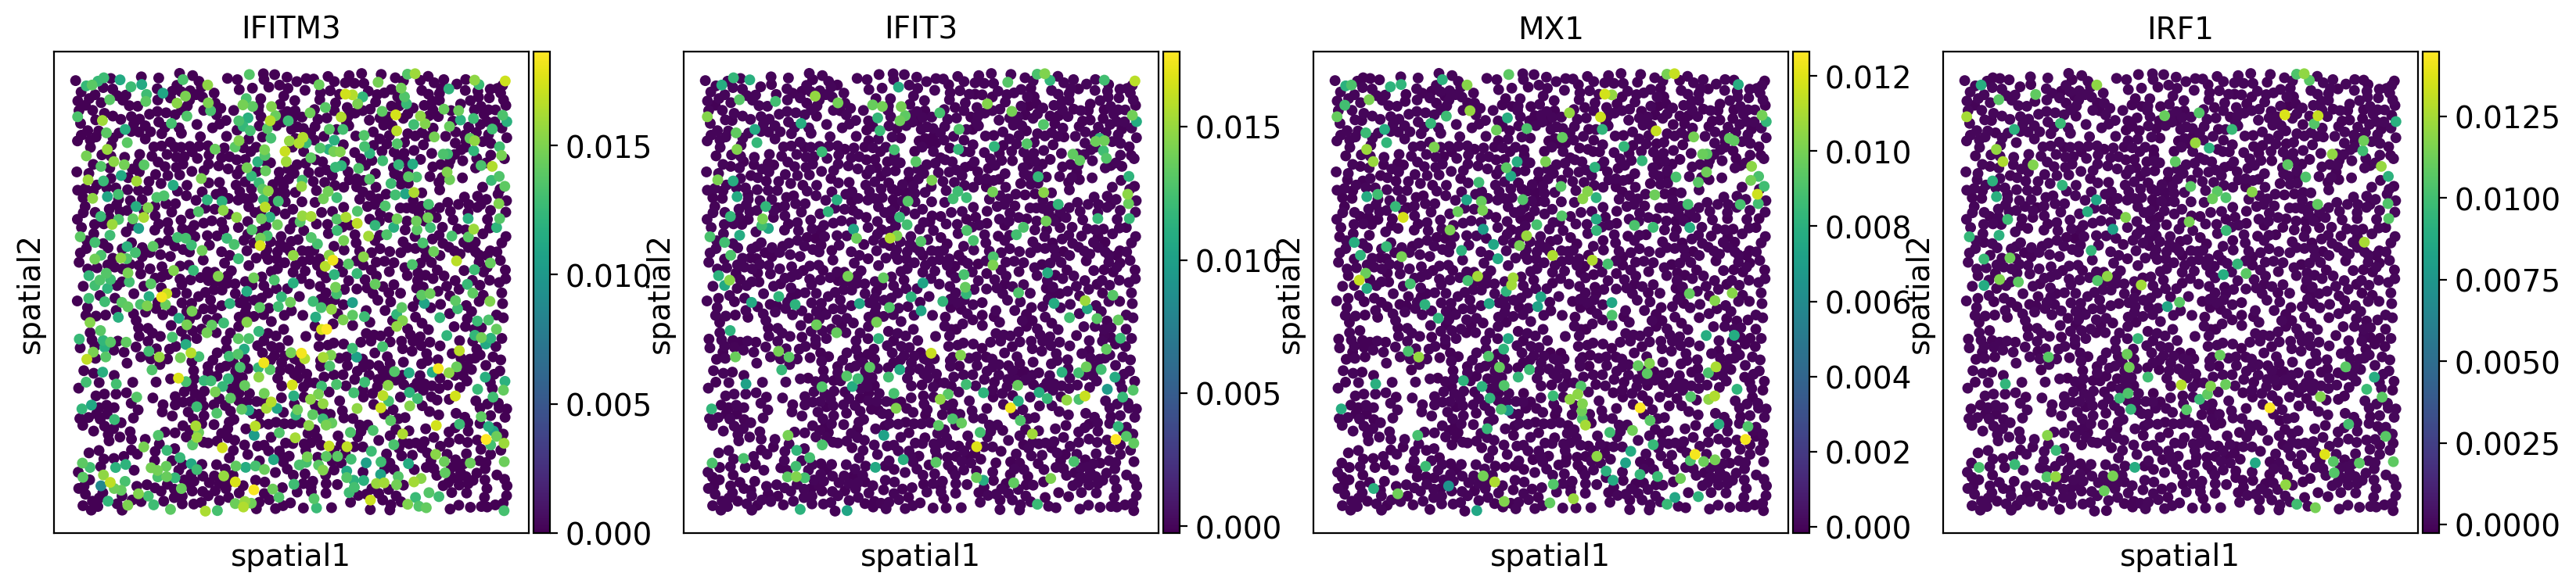

In [16]:
# find the genes of interest
genes = ['IFITM3','IFIT3','MX1','IRF1']
genes = [x for x in genes if x in avis_sub.var_names.tolist()]
# add the layers
for idx, tmp_gex in enumerate(tmp_gexs):
    avis_sub.layers[f'input{idx}'] = tmp_gex
avis_sub.layers['output'] = output_gex
# plot the genes of interest
sc.pl.embedding(avis_sub, basis='spatial', color=genes, use_raw=False, s=1e2, layer='input0')
sc.pl.embedding(avis_sub, basis='spatial', color=genes, use_raw=False, s=1e2, layer='input3')
sc.pl.embedding(avis_sub, basis='spatial', color=genes, use_raw=False, s=1e2, layer='output')

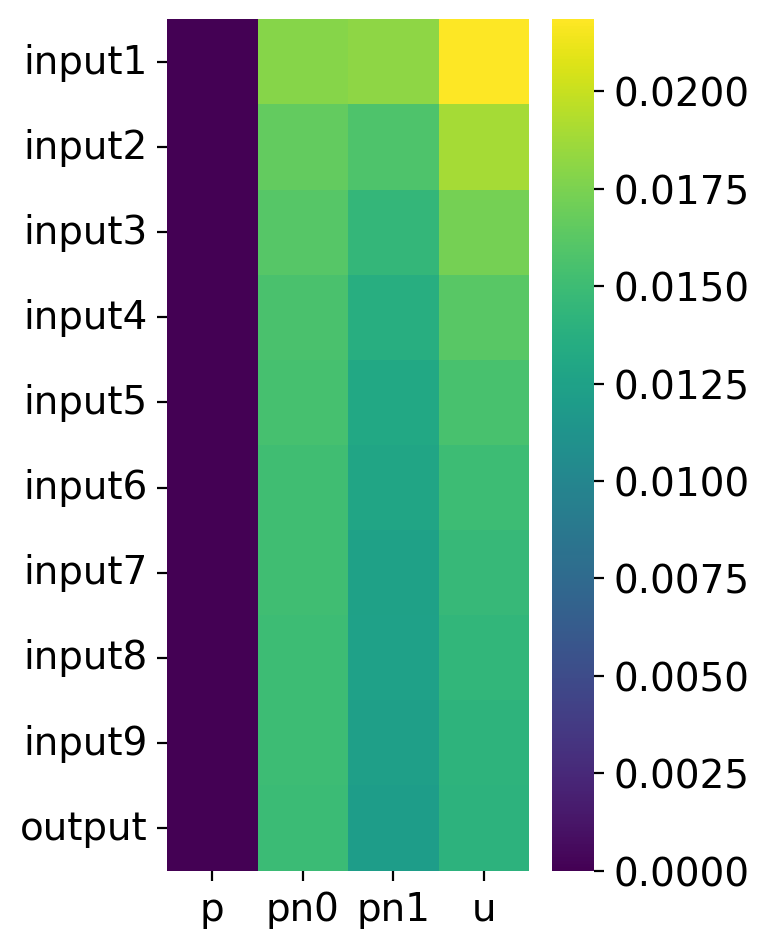

In [17]:
# compute the differential within the area of interest vs outside
avis_sub.layers['diff'] = avis_sub.layers['output'] - avis_sub.layers['input0']
mask0 = avis_sub.obs['perturbed'] == 'unperturbed'
mask1 = avis_sub.obs['perturbed'] == 'perturbed'
diff_in_vs_out_p = pd.Series((avis_sub.layers['diff'][mask1].mean(0) - avis_sub.layers['diff'][mask0].mean(0)),
                             index=avis_sub.var_names).sort_values()[::-1]
# now compute differential for neighbors
mask1 = avis_sub.obs['perturbed'] == 'perturbed-neighbors0'
diff_in_vs_out_pn0 = pd.Series((avis_sub.layers['diff'][mask1].mean(0) - avis_sub.layers['diff'][mask0].mean(0)),
                             index=avis_sub.var_names).sort_values()[::-1]
mask1 = avis_sub.obs['perturbed'] == 'perturbed-neighbors1'
diff_in_vs_out_pn1 = pd.Series((avis_sub.layers['diff'][mask1].mean(0) - avis_sub.layers['diff'][mask0].mean(0)),
                             index=avis_sub.var_names).sort_values()[::-1]
# remove the perturbed genes to get a clean look
perturbed_genes = ['IFITM3']
perturbed_label = 'ifitm3'
diff_in_vs_out_p = diff_in_vs_out_p.loc[~diff_in_vs_out_p.index.isin(perturbed_genes)]
diff_in_vs_out_pn0 = diff_in_vs_out_pn0.loc[~diff_in_vs_out_pn0.index.isin(perturbed_genes)]
diff_in_vs_out_pn1 = diff_in_vs_out_pn1.loc[~diff_in_vs_out_pn1.index.isin(perturbed_genes)]
# write these matrices out
diff_in_vs_out_p.to_csv(f'learn_then_perturb.xenium_gbm.{perturbed_label}.diff_in_vs_out_p.csv')
diff_in_vs_out_pn0.to_csv(f'learn_then_perturb.xenium_gbm.{perturbed_label}.diff_in_vs_out_pn0.csv')
diff_in_vs_out_pn1.to_csv(f'learn_then_perturb.xenium_gbm.{perturbed_label}.diff_in_vs_out_pn1.csv')
# do not include isg15 itself
genes_ = pd.DataFrame(avis_sub.uns['rank_genes_groups']['names']).iloc[:25, 0].tolist()[1:]
# retrieve the results
df_expr = pd.DataFrame(columns=['p','pn0','pn1','u'])
for layer in ['input1','input2','input3','input4','input5','input6','input7','input8','input9','output']:
    # compute the expression
    mask1 = avis_sub.obs['perturbed'] == 'perturbed'
    expr_p = pd.Series(avis_sub.layers[layer][mask1].mean(0), index=avis_sub.var_names).loc[genes_].mean()
    mask1 = avis_sub.obs['perturbed'] == 'perturbed-neighbors0'
    expr_pn0 = pd.Series(avis_sub.layers[layer][mask1].mean(0), index=avis_sub.var_names).loc[genes_].mean()
    mask1 = avis_sub.obs['perturbed'] == 'perturbed-neighbors1'
    expr_pn1 = pd.Series(avis_sub.layers[layer][mask1].mean(0), index=avis_sub.var_names).loc[genes_].mean()
    mask1 = avis_sub.obs['perturbed'] == 'unperturbed'
    expr_u = pd.Series(avis_sub.layers[layer][mask1].mean(0), index=avis_sub.var_names).loc[genes_].mean()
    df_expr.loc[layer] = expr_p, expr_pn0, expr_pn1, expr_u
# derive the scores
fig, ax = plt.subplots(figsize=[2.9, 5.6])
ax = sns.heatmap(df_expr, cmap='viridis')
ax.grid(False)